In [2]:
import os
from typing import List, Annotated
from pydantic import BaseModel
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain.schema import Document
from langgraph.graph import StateGraph, END

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=init_chat_model("openai:gpt-4o")
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000023894B56CF0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000023894B57770>, root_client=<openai.OpenAI object at 0x0000023894B54440>, root_async_client=<openai.AsyncOpenAI object at 0x0000023894B574D0>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********'))

In [5]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
    ]
loaders = [WebBaseLoader(url) for url in urls]
docs = []
for loader in loaders:
    docs.extend(loader.load())
    docs

In [8]:
## Recursive character text ssplitter an vectorstore\n",
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
split_docs = splitter.split_documents(docs)
embedding = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(split_docs, embedding)
retriever = vectorstore.as_retriever()

In [9]:
retriever.invoke("What are agents")

[Document(id='af5d3e56-a665-41b7-a1fd-07c1fbc1d035', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [11]:
# Define RAG State

class RAGState(BaseModel):
    question: str
    retrieved_docs: List[Document] = []
    answer: str = ""

In [12]:
# LangGraph Nodes

def retrieve_docs(state: RAGState) -> RAGState:
    docs = retriever.invoke(state.question)
    return RAGState(question=state.question, retrieved_docs=docs)
def generate_answer(state: RAGState) -> RAGState:
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"Answer the question based on the context.Context:{context} Question: {state.question}"
    response = llm.invoke(prompt)
    return RAGState(question=state.question, retrieved_docs=state.retrieved_docs, answer=response.content)

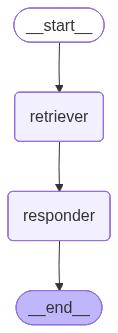

In [13]:
# Build LangGraph

builder = StateGraph(RAGState)
builder.add_node("retriever", retrieve_docs)
builder.add_node("responder", generate_answer)
builder.set_entry_point("retriever")
builder.add_edge("retriever", "responder")
builder.add_edge("responder", END)
graph = builder.compile()
graph

In [14]:
# Run the Agentic RAG

if __name__ == "__main__":
    user_question = "What is the concept of agent loop in autonomous agents?"
    initial_state = RAGState(question=user_question)
    final_state = graph.invoke(initial_state)
    print("✅ Final Answer:", final_state['answer'])

✅ Final Answer: The concept of the agent loop in autonomous agents typically refers to a cycle of operations that the agent continuously goes through to function effectively. This loop integrates various mechanisms such as memory, planning, reflection, and action, enabling the agent to perform tasks autonomously by using past experiences and adapting to new inputs.

In the context of generative agents, an agent loop often involves stages where the agent starts with perception or input gathering (e.g., data from the environment), followed by reasoning (e.g., planning and decision-making), taking actions based on those decisions, and self-reflecting on the outcomes. Self-reflection, in this context, allows the agent to refine its future actions based on the effectiveness of previous actions, thereby leading to iterative improvement and adaptation. Through this continuous cycle, autonomous agents are able to handle complex tasks, make informed decisions, and interact with other agents or 